<a href="https://colab.research.google.com/github/AlexMa123/BIU-Computational-Physics-2022/blob/main/Lecture3%20-%20Percolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Percolation

## Review

Percolation is the study of connectivity of random media and of other properties of connected subsets of random media. The study of percolation has brought new understanding and techniques to a broad range of topics in physics, materials science, complex networks, epidemiology, and other fields.

|![example of percolation](https://upload.wikimedia.org/wikipedia/commons/thumb/9/92/Manual_coffee_preperation.jpg/1024px-Manual_coffee_preperation.jpg)|
|:-:|
|*Fig1.1: a) Examples of percolation: In coffee percolation, soluble compounds leave the coffee grounds and join the water to form coffee. Insoluble compounds (and granulates) remain within the coffee filter.*|

### site percolation

Let's study the simplest example of a random medium. Generate an L $\times$ L matrix where each element is occupied with probability p. Assume the occupied sites are considered to be holes in the porous material.

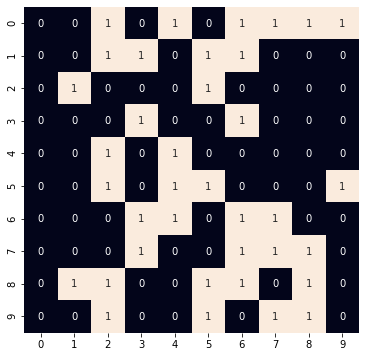

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # for plot heatmap

p = 0.4 # occupation probability
# generate a matrix filled with random numbers uniformly distributed between 0 to 1
random_matrix = np.random.rand(10, 10)
# if the element in random_matrix smaller than p, set it as True, otherwise, equal to False
m = random_matrix < p
# change True to 1, False to 0
m = m.astype(int)
plt.figure(figsize=(6, 6))
sns.heatmap(m, annot=m, cbar=False)
plt.show()

### Label clusters

Once we have this material (matrix), we can start to study the connectivity between the holes (sites). The two sites are connected if they are nearest neighbors (4 neighbors on a square lattice), and the set of connected sites is a cluster. If the cluster spans from the top to the bottom, it is called an infinity cluster. **The system is percolating if there is an infinity cluster in the system.**

To determine the clusters in a matrix, we can use the `Hoshen-Kopelman-Algorithm`, and luckily, there is a build-in function in scipy to find out the clusters

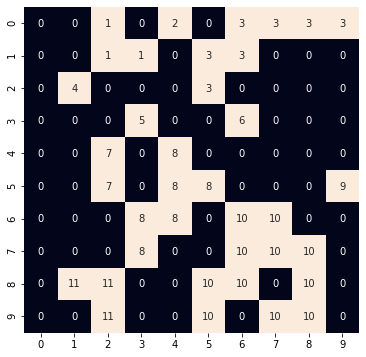

In [ ]:
from scipy.ndimage import measurements
# lm: labeled matrix, num: number of clusters in the given system
lm, num = measurements.label(m)
plt.figure(figsize=(6, 6))
sns.heatmap(m, annot=lm, cbar=False)
plt.show()

### Calculate the size / mass of each cluster
We can use measurements.sum to calculate the size of labels.

This function can sum up all the elements in a matrix that is labeled as index, just by 
```python
measurements.sum(matrix, label, index)
```

<AxesSubplot:>

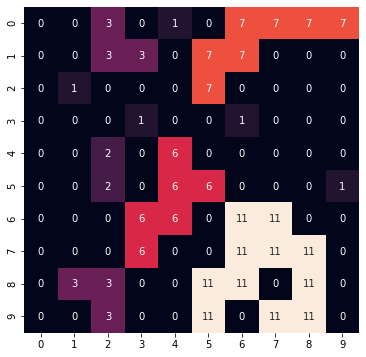

In [ ]:
size = measurements.sum(m, lm, index=range(num+1))
sizeImg = size[lm]
plt.figure(figsize=(6, 6))
sns.heatmap(sizeImg, annot=sizeImg, cbar=False)

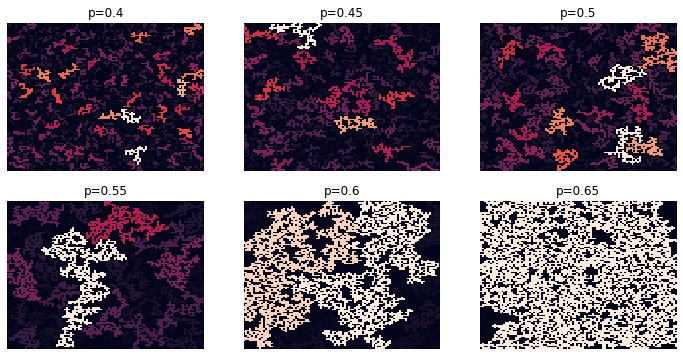

In [ ]:
L = 100
ps = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65]
plt.figure(figsize=(12, 6))
for i in range(len(ps)):
    p = ps[i]
    m = (np.random.rand(L, L) < p).astype(int)
    lm, num = measurements.label(m)
    area = measurements.sum(m, lm, index=range(num+1))
    plt.subplot(2, 3, i+1)
    sns.heatmap(area[lm], cbar=False)
    plt.title(f"p={p}")
    plt.axis('off')

### Whether the system has an infinity cluster or not. 

In [ ]:
p = 0.6
L = 100
# generate random matrix and label clusters
m = (np.random.rand(L, L) < p).astype(int)
lm, num = measurements.label(m)
# findout whether the first and last row have the same cluster
perc_x = np.intersect1d(lm[0], lm[-1])
perc_x.max() > 0

False

From the figure shown above, we can see that there are two different phases: a phase with an infinity cluster (large p) and a phase without an infinity cluster (small p)
### Order Parameter
An order parameter distinguishes the two different phases (or orders). In one phase the order parameter is zero and in another phase it is non-zero. 

For percolation, we can choose the probability that one site belongs to the infinity cluster, $P_{\infty}(p)$ as the order parameter. When p is smaller than the critical probability $p_c$, there is no infinity cluster, $P_{\infty}=0$, and when p is larger than $p_c$, $P_{\infty}$ will be non-zero

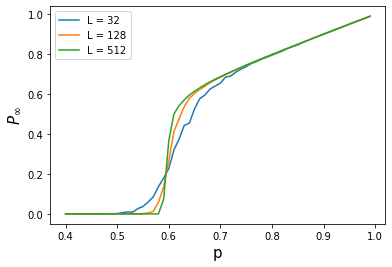

In [ ]:
from numba import njit

def p_inf(L, p, n=100):
    area_inf = 0
    for i in range(n):
        z = np.random.rand(L, L)
        m = (z < p)
        lm, num = measurements.label(m)
        perc_x = np.intersect1d(lm[0], lm[-1])
        if perc_x.max() > 0:
            area = measurements.sum(m, lm, perc_x)
            area_inf = area_inf + area.sum()
    return area_inf / n / L / L

for l in [32, 128, 512]:
    ps = np.arange(0.4, 1, 0.01)
    pinf = np.zeros_like(ps)
    for i in range(ps.size):
        pinf[i] = p_inf(l, ps[i], n=100)

    plt.plot(ps, pinf, label=f'L = {l}')
plt.xlabel("p", fontsize=15)
plt.ylabel(r"$P_{\infty}$", fontsize=15)
plt.legend()

#### Critical exponent $\beta$
$$P_{\infty}(p) \sim (p - p_c)^{\beta}$$

and $\beta = 5 / 36$ for 2d square lattice

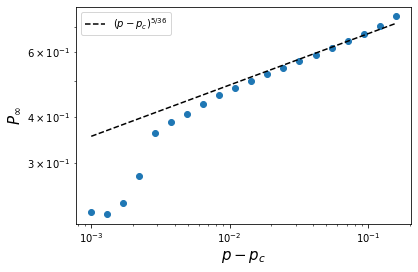

In [ ]:
pc = 0.59274621
delta_p = np.logspace(-3, -0.8, 20)
pinf = np.zeros_like(delta_p)
for i in range(delta_p.size):
    pinf[i] = p_inf(2048, pc + delta_p[i], 50)

plt.plot(delta_p, pinf, 'o')
plt.plot(delta_p, (delta_p / delta_p[-4]) ** (5 / 36) * pinf[-4], 
         'k--', label=r'$(p - p_c)^{5 / 36}$')
plt.xlabel('$p - p_c$', fontsize=15)
plt.ylabel('$P_{\infty}$', fontsize=15)
plt.legend()
plt.xscale('log')
plt.yscale('log')

### Structural properties of percolation clusters

### Average Size of the finite clusters
If there are N finite clusters in the system, and the size of the $k$th cluster is $s_k$, the average cluster size is : $\frac{1}{N} \sum s_k$. Here, each cluster has equal weight.

However, there is an alternative form of averaging where each cluster is weighted according to its size, giving more weight to large clusters:

$$S(q) = \chi (q) = \frac{1}{N} \sum s_k^2$$

Text(0, 0.5, '$\\chi (p)$')

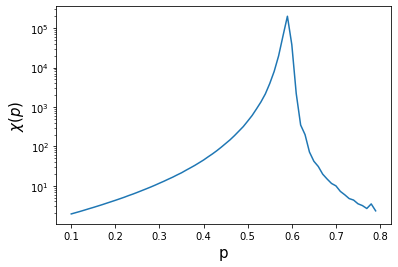

In [ ]:
def ave_size(L, p, n=100):
    total_size = 0
    n_clusters = 0
    for i in range(n):
        z = np.random.rand(L, L)
        m = (z < p)
        lm, num = measurements.label(m)
        perc_x = np.intersect1d(lm[0], lm[-1])
        size = measurements.sum(m, lm, range(num+1))
        size = np.sort(size)
        if perc_x.max() > 0:
            size = size[:-1]
        total_size += (size ** 2).sum()
        n_clusters = n_clusters + size.size
            
    return total_size / n_clusters



ps = np.arange(0.1, 0.8, 0.01)
S = np.zeros_like(ps)
for i in range(ps.size):
    S[i] = ave_size(500, ps[i], 50)
    
plt.plot(ps, S)
plt.yscale('log')
plt.xlabel("p", fontsize=15)
plt.ylabel(r"$\chi (p)$", fontsize=15)

#### Critical exponent $\gamma$
$$ \chi(q) \sim |p-p_c|^{-\gamma}$$
and $\gamma = 43 / 18$ for 2d square lattice

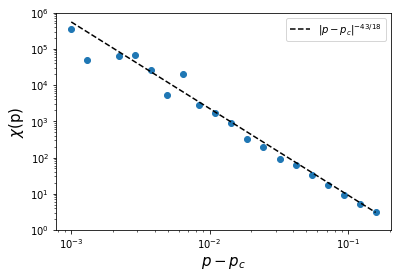

In [ ]:
pc = 0.59274621
delta_p = np.logspace(-3, -0.8, 20)
S = np.zeros_like(delta_p)
for i in range(delta_p.size):
    S[i] = ave_size(5000, pc + delta_p[i], 1)

plt.plot(delta_p, S, 'o')
plt.plot(delta_p, (delta_p / delta_p[-1]) ** (- 43 / 18) * S[-1], 
         'k--', label = r'$|p-p_c|^{- 43 / 18}$')
plt.ylim(1, 10**6)
plt.xlabel(r'$p - p_c$', fontsize=15)
plt.ylabel(r'$\chi$(p)', fontsize=15)
plt.legend()
plt.xscale('log')
plt.yscale('log')

### Correlation length

We can also measure the typical size of a cluster from the correlation function, which is correlation length
#### Correlation function
The correlation function g(r, p), which is the probability that two sites, which are a distance r apart, are connected and part of the same finite cluster for a system with occupation probability p.

In [ ]:
from numba import njit
# from math import round
@njit
def correlation(lm):
    nx, ny = lm.shape
    r = np.arange(max(nx, ny) * 2)
    pr = np.zeros(r.shape) # correlation function
    npr = np.zeros_like(pr) # Nr of elements
    perc_x = set(lm[0]).intersection(set(lm[-1]))
    perc_x = sorted(perc_x)
    perc_x = perc_x[1:]
    if len(perc_x) != 0:
        has_inf = True
    else:
        has_inf = False
    for ix1 in range(nx):
        for iy1 in range(ny):
            label1 = lm[ix1, iy1]
            if label1 > 0:
                if has_inf and label1 in perc_x:
                    continue
                for ix2 in range(nx):
                    for iy2 in range(ny):
                        dr = np.sqrt((ix1 - ix2) ** 2 + (iy1 - iy2) ** 2)
                        nr = int(dr)
                        npr[nr] = npr[nr] + 1
                        if lm[ix2, iy2] == label1:
                            pr[nr] = pr[nr] + 1
    return r, pr, npr

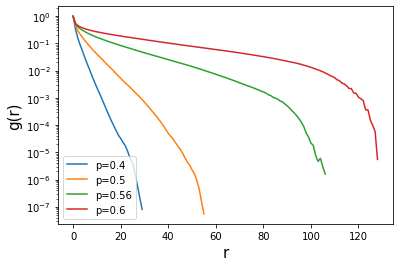

In [ ]:
for p in [0.4, 0.5, 0.56, 0.6]:
    L = 100
    # generate random matrix and label clusters
    pr = np.zeros(L * 2)
    npr = np.zeros(L * 2)
    for i in range(100):
        m = (np.random.rand(L, L) < p).astype(int)
        lm, num = measurements.label(m)
        r, pr_tmp, npr_tmp = correlation(lm)
        pr = pr + pr_tmp
        npr = npr_tmp + npr

    pr[pr > 0] = pr[pr > 0] / npr[pr > 0]
    plt.plot(r[pr > 0], pr[pr > 0], label=f'p={p}')

plt.yscale('log')
plt.legend()
plt.xlabel('r', fontsize=15)
plt.ylabel('g(r)', fontsize=15)
plt.show()

#### Correlation length
And the correlation length is:
$$\xi(p) = \frac{\int r g(r, p) dr}{ \int g(r, p) dr}$$

In [ ]:
from joblib import Parallel, delayed
def corrlength(L, p, n=10):
    pr = np.zeros(L * 2)
    npr = np.zeros(L * 2)
    for i in range(n):
        m = (np.random.rand(L, L) < p).astype(int)
        lm, num = measurements.label(m)
        r, pr_tmp, npr_tmp = correlation(lm)
        pr = pr + pr_tmp
        npr = npr + npr_tmp
    pr[pr > 0] = pr[pr > 0] / npr[pr > 0]
    length = (r * pr).sum() / pr.sum()
    return length

ps = np.arange(0.1, 0.8, 0.02)

cl = Parallel(n_jobs=6)(
    delayed(corrlength)(200, p, n=50) for p in ps
)


Text(0.5, 0, 'p')

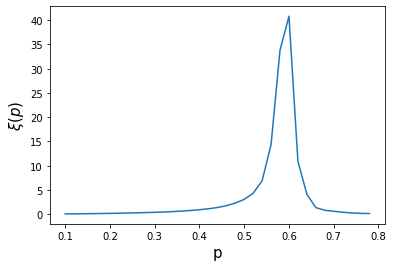

In [ ]:
plt.plot(ps, cl)
plt.ylabel(r'$\xi(p)$', fontsize=15)
plt.xlabel('p', fontsize=15)

#### Critical exponent $\nu$
$$\xi(p) \sim |p - p_c| ^ {-\nu}$$
and $\nu = 4 / 3$ for 2d square lattice

In [ ]:
from joblib import Parallel, delayed
pc = 0.59274621
delta_p = np.logspace(-2, -0.8, 20)
cl = Parallel(n_jobs=6)(
    delayed(corrlength)(500, pc + dp, n=10) for dp in delta_p
)

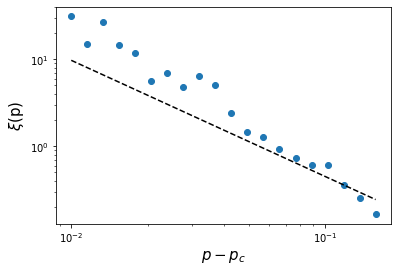

In [ ]:
plt.plot(delta_p, cl, 'o')
plt.plot(delta_p, (delta_p / delta_p[-3]) ** (-4 / 3) * cl[-3], 
         'k--', label=r'$|p-p_c|^{4/3}$')
plt.xlabel(r'$p - p_c$', fontsize=15)
plt.ylabel(r'$\xi$(p)', fontsize=15)
plt.legend()
plt.yscale('log')
plt.xscale('log')

### Renormalisation in percolation theory

In theoretical physics, the term renormalization group (RG) refers to a formal apparatus that allows systematic investigation of the changes of a physical system as viewed at different scales.

The real space renormalisation is based on the so-called block site (spin) technique introduced by Leo Kadanoff.

The renormalisation group method has three basis steps:
1. Divide the lattice into blocks of linear size b with each block containing a few sites (spin)
2. Replace each block of sites by a single block site of size b which is occupied with probability $R_b(p)$ according to the renormalisation group transformation.
3. Restore original lattice constant by rescaling the length scales by the factor b.


|![example of renormalisation](https://github.com/AlexMa123/BIU-Computational-Physics-2022/blob/main/img/percolation/renormalisation.png?raw=true)|
|:-:|
|*Real-space renormalisation group transformation fo two-dimensional site percolation on a square lattice with sites of size a. Sites are occupied with probability p. (a) The lattice is divided into blocks of size ba, each containing $b^2$ sites. {b) Each block is coarse grained and all of its sites are replaced by a single block site of size ba occupied with probability $R_b(p)$. {c) All length scales are reduced by the factor b. The block size is thereby reduced to a, the same size as the sites in the original lattice: block sites become sites. We therefore obtain a rescaled version of the original lattice where, because of coarsening, sites are occupied with probability R_b(p).*|

#### Renormalisation in 2d square lattice
For simplify the coarse graining, consider b = 2. When there is a spaning cluster in one block, we occupied this block. 

|![Rb for 2d lattice](https://github.com/AlexMa123/BIU-Computational-Physics-2022/blob/main/img/percolation/renormalisation_2d_lattice.png?raw=true)|
|:-:|
|*16 different configurations of a b = 2 block containing 4 sites for 2d site percolation on a square lattice. the left configurations have a vertically spanning cluster and by adding the probabilities for each configuration, we can find $R_b(p)$*|


So $R_b(p) = 2 p ^ 2 - p^4$

It means, after the rescaling, the new figure is equvalent to a percolation system with an occupation probability $R_b(p)$. The systems generate under the $p^*$ that make $R_b(p^*) = p^*$ are the scale-invarance systems. We can find 3 fixed points: $0, (\sqrt{5} - 1) / 2$ and $1$. 0 and 1 are two trivial states, which are just the state are occupied or not occupied. $p ^ * - (\sqrt{5} - 1) / 2$ is the only non-trivial scale-invarance state.

|![Rb for 2d lattice](https://github.com/AlexMa123/BIU-Computational-Physics-2022/blob/main/img/percolation/renormalisation_different_p.png?raw=True)|
|:-:|
|*Real-space renormalisation group transformation of two-dimensional site percolation on a square lattice.*|


# Exercises

1. Summarize what you have learned about percolation

2. Implement Hoshen-Kopelman-Algorithm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import seaborn as sns


# hoshen-kopelman algorithm
@njit
def hoshen_kopelman(img):
    """
    The usage of this function should be the same with measurments.label(img)
    1. start from img[0, 0], scan the matrix from left to right, top to bottom:
    img[0, 0], img[0, 1], img[0, 2] ... img[0, N], img[1, 0], img[1, 1] .. img[N, N]
    2. when img[i, j] != 0
    if img[i, j - 1] = img[i - 1, j] = 0:
        set img[i, j] as a new label
    if img[i, j - 1] != 0 but img[i - 1, j] = 0:
        set img[i, j] as img[i, j - 1]
    if img[i - 1, j] != 0 but img[i, j - 1] = 0:
        set img[i, j] as img[i - 1, j]
    if img[i - 1, j] = img[i, j - 1] != 0:
        set img[i, j] as img[i - 1, j]
    if img[i - 1, j] != img[i, j - 1] != 0:
        smaller_label = min(img[i - 1, j], img[i, j - 1])
        set img[i, j] as the smaller_label, and reset all the site labeled as the
        larger label as the smaller_label. This step is called Union-find, you can use
        the function find_set(labels, i, j, label) to do it.
    """
    raise NotImplementedError


@njit
def find_set(labels, i, j, label):
    """
    set the element labels[i, j] as label, and also set the other sites which belong to
    the same cluster with labels[i, j] before as label.
    """
    labels[i, j] = label
    if i - 1 >= 0 and labels[i - 1, j] != 0 and labels[i - 1, j] != label:
        find_set(labels, i - 1, j, label)
    if j - 1 >= 0 and labels[i, j - 1] != 0 and labels[i, j - 1] != label:
        find_set(labels, i, j - 1, label)
    if j + 1 < labels.shape[1] and labels[i, j + 1] != 0 and labels[i, j + 1] != label:
        find_set(labels, i, j + 1, label)
#%%



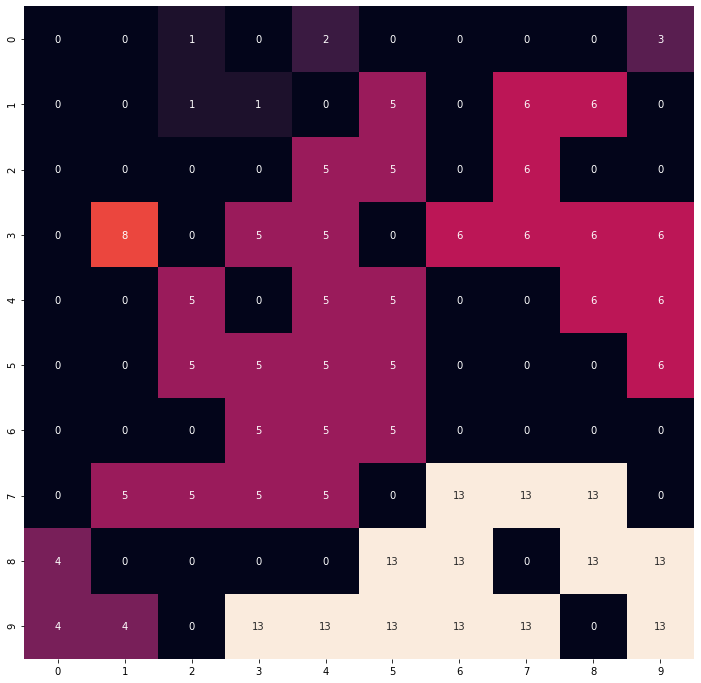

In [ ]:
# for testing Hoshen-Kopelman-Algorithm
N = 10
p = 0.6
m = np.random.rand(N, N)
m = (m < p).astype(int)

labels = hoshen_kopelman(m)
plt.figure(figsize=(12, 12))
sns.heatmap(labels, annot=labels, cbar=False)
plt.show()

3. How does the mass, or number of sites M(L) of the largest cluster grow with size L of the lattice? Reproduce the figure on slide 13. Also apply a polynomial fit to determine the $d_f$

when p = $p_c$ and p > $p_c$

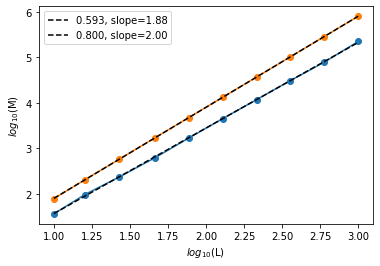

when p < $p_c$

Text(0, 0.5, 'M(L)')

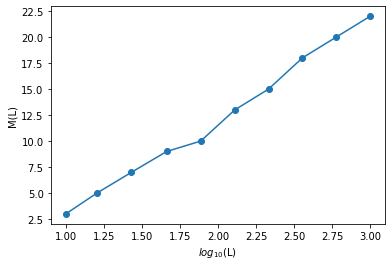

4. Renormalization on triangular lattice
Try to find out $p_c$ by using renormalization. Compare your result with the real Percolation threshold. You can find the real value from : https://en.wikipedia.org/wiki/Percolation_threshold


|![triangular lattice](https://github.com/AlexMa123/BIU-Computational-Physics-2022/blob/main/img/percolation/tra_percolation.png?raw=True)|
|:-:|
|*triangular lattice*|

|![triangular lattice](https://github.com/AlexMa123/BIU-Computational-Physics-2022/blob/main/img/percolation/tra_percolation_cg.png?raw=True)|
|:-:|
|*coarse graining rule for triangular lattice*|

